In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 4.5)

from util import util
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd

# Load data
data_folder = os.path.join('..', 'data')
data = util.load_cmapss_data(data_folder)

# Identify input columns
dt_in = list(data.columns[3:-1])

# Knowledge Injection in ML

There are more things in heaven and earth, Horation, than in your dataset

## Data ⊂ Knowledge

**ML methods excel at taking advantage of _implicit_ knowledge _from data_**

...But not all knowledge comes in the form of datasets!

* Rules of thumb, rough estimates
* Know correlations and causal factors
* Laws of physics
* ...

Knowledge from these sources is typically in _explicit_ form

**Exploiting this information is critical in many practical applications**

Many domains can boast _decades of field knowledge_ and specialized methods

* Trying to replace those with pure data-driven approaches can be challenging
* ...And it can encounter a lot of resistance

## Knowledge Injection in ML

**It would be far preferable to account for _all available information_**

...Including both _explicit_ and _implicit_ knowledge

* Implicit knowledge (data) is well-covered by ML methods
* ...But explicit knowledge used to be the domain of symbolic AI

How can we combined both?

**We could go for a "generative" approach**

* We rely on symbolic knowledge for generating new examples
* ...Then we proceed as usual in ML

This how things are done in data augentation

> **...But is that really the only approach?**

## Knowledge as Constraints

**Knowledge can be though of _as a constraint_**

E.g. predictions should satisfy certain symbolic properties

* Predictions should lay within an interval
* Predictions should be robust w.r.t. variations
* ...

> **So, enforcing constraints is a way to _"inject knowledge"_ in ML**

**The enforced constraints can be _hard_ or _soft_:**

* Hard constraints should always hold
* Soft constraints are expected to be violated to a some degree

<div class=big>
Let's consider a use case for the idea of injecting knowledge via constraints
</div>

## Scarce Labels in RUL Predictions

**_RUL estimation_ is the holy grail of predictive maintenance**

RUL stands for "Remaining Useful Life"

* If you can predict when a machine will fail
* ...Then you can plan maintenance in the best possible way

**However, ground truth for RUL is hard to come by**

...Since it requires performing run-to-failure experiments

* These are time-consuming (machines are not designed to break)
* ...Costly (machines can be expensive)
* ...And difficult to perform (e.g. for complex machines)

Typically, _only a few runs_ are available

## Scarce Labels in RUL Predictions

**On the other hand, data about _normal_ operation is abundant**

This may come from test runs, installed machines, etc.

* Those machines will not be in a critical state
* ...But they will still show sign of component wear

**In practice:, for normal operation**

* We have access to the same observable as in run-to-failure experiments
* ...But we have _no ground truth_

> **Can we still take advantage of this data?**

## Data Loading and Preparation

**We will rely on the [NASA C-MAPPS dataset](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/)**

...Which contains simulated run-to-failure experiments for turbo-fan engines

In [2]:
data.head()

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD004,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,train_FD004,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,train_FD004,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,train_FD004,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,train_FD004,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


* There are four sub-datasets (column `src`)
* Columns `p1-3` represent control parameters
* Columns `s1-21` are sensor readings

## Data Loading and Preparation

**We will focus on the FD004 dataset (the hardest)**

In [3]:
data_by_src = util.partition_by_field(data, field='src')
dt = data_by_src['train_FD004']

**Then we separate _two sets for training_ and one for testing**

* The first trainign set will contain finished experiments (supervised)
* ...The second will contain data for still running machines (unsupervised)

In [4]:
trs_ratio = 0.03 # Supervised experiments / all experiments
tru_ratio = 0.6 # Unsupervised experiments / remaining experiments
trs, tmp = util.split_datasets_by_field(dt, field='machine', fraction=trs_ratio, seed=42)
tru, ts = util.split_datasets_by_field(tmp, field='machine', fraction=tru_ratio, seed=42)

trs_mcn, tru_mcn, ts_mcn = trs['machine'].unique(), tru['machine'].unique(), ts['machine'].unique()
print(f'Num. machine: {len(trs_mcn)} (supervised), {len(tru_mcn)} (unsupervised), {len(ts_mcn)} (test)')

Num. machine: 7 (supervised), 145 (unsupervised), 97 (test)


## Data Loading and Preparation

**Then we standardize the input data**

In [5]:
sscaler, nscaler = StandardScaler(), MinMaxScaler()
trs_s, tru_s, ts_s = trs.copy(), tru.copy(), ts.copy()
trs_s[dt_in] = sscaler.fit_transform(trs[dt_in])
tru_s[dt_in], ts_s[dt_in] = sscaler.transform(tru[dt_in]), sscaler.transform(ts[dt_in])
trs_s[['rul']] = nscaler.fit_transform(trs[['rul']])
tru_s[['rul']], ts_s[['rul']] = nscaler.transform(tru[['rul']]), nscaler.transform(ts[['rul']])

maxrul = nscaler.data_max_[0]
display(trs_s.head())

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
1725,train_FD004,7,1,-1.688818,-1.924463,0.445653,1.811019,1.784571,1.676983,1.834240,...,0.445850,0.741155,-1.182014,1.456084,1.710890,1.126932,0.445653,1.912053,1.883875,0.901639
1726,train_FD004,7,2,-0.320795,0.385443,0.445653,0.754416,0.824865,0.604660,0.459056,...,0.445776,-0.158233,-0.209914,-0.686773,0.662255,0.697974,0.445653,0.422743,0.432957,0.897541
1727,train_FD004,7,3,-1.688920,-1.925123,0.445653,1.811019,1.768351,1.668955,1.823341,...,0.445477,0.684593,-1.247749,1.456084,1.747049,1.126932,0.445653,1.912053,1.891484,0.893443
1728,train_FD004,7,4,1.184267,0.844852,0.445653,-1.021583,-0.742836,-0.576936,-0.541685,...,0.443309,0.078654,0.017101,-0.686773,-0.531018,-0.052704,0.445653,-0.987588,-0.988312,0.889344
1729,train_FD004,7,5,-1.688948,-1.925453,0.445653,1.811019,1.767810,1.726472,1.761244,...,0.445402,0.677537,-1.249832,1.456084,1.710890,1.126932,0.445653,1.908976,1.922090,0.885246


Later, we will need the maximum RUL value on the training set

## Removing RUL Values

**Next, we simulate the lack of RUL values on the unsupervised data**

* We copy the unsupervised data and _remove number of their last entries_
* Then, _we replace RUL values_ with -1 (invalid)
* Finally, we merge supervised and unsupervised data in a single dataset

In [12]:
tru_s2 = util.rul_cutoff_and_removal(tru_s, cutoff_min=20, cutoff_max=60, seed=42)
tr_s2 = pd.concat((trs_s, tru_s2))
tr_s2.head()

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
1725,train_FD004,7,1,-1.688818,-1.924463,0.445653,1.811019,1.784571,1.676983,1.834240,...,0.445850,0.741155,-1.182014,1.456084,1.710890,1.126932,0.445653,1.912053,1.883875,0.901639
1726,train_FD004,7,2,-0.320795,0.385443,0.445653,0.754416,0.824865,0.604660,0.459056,...,0.445776,-0.158233,-0.209914,-0.686773,0.662255,0.697974,0.445653,0.422743,0.432957,0.897541
1727,train_FD004,7,3,-1.688920,-1.925123,0.445653,1.811019,1.768351,1.668955,1.823341,...,0.445477,0.684593,-1.247749,1.456084,1.747049,1.126932,0.445653,1.912053,1.891484,0.893443
1728,train_FD004,7,4,1.184267,0.844852,0.445653,-1.021583,-0.742836,-0.576936,-0.541685,...,0.443309,0.078654,0.017101,-0.686773,-0.531018,-0.052704,0.445653,-0.987588,-0.988312,0.889344
1729,train_FD004,7,5,-1.688948,-1.925453,0.445653,1.811019,1.767810,1.726472,1.761244,...,0.445402,0.677537,-1.249832,1.456084,1.710890,1.126932,0.445653,1.908976,1.922090,0.885246


## MLP with Scarce Labels

**As a baseline, we will train a MLP model _on the supervised data_**

We do not split a validation set, given we have scarce data

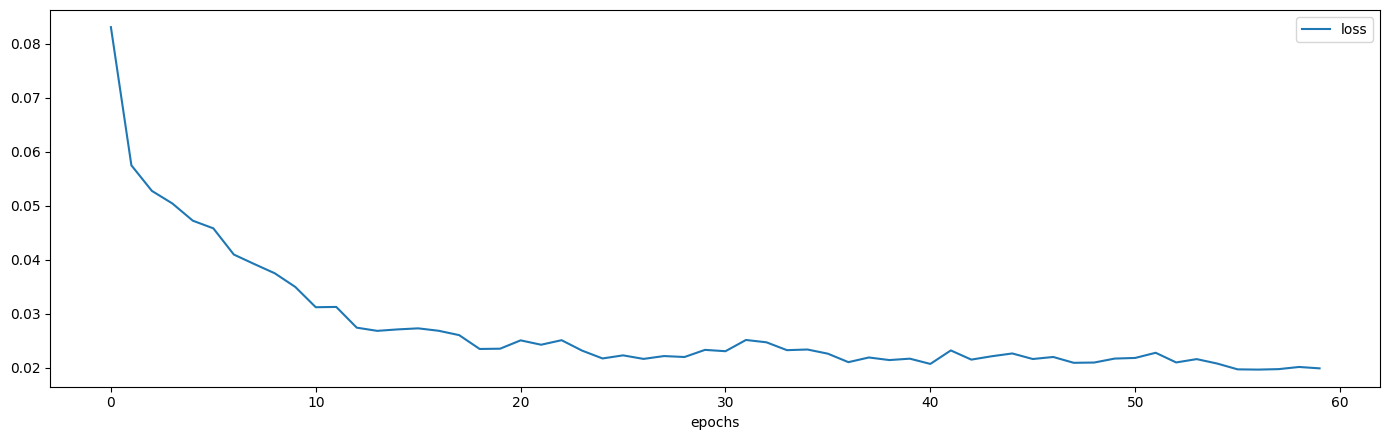

Model loss: 0.0199 (training)


In [6]:
nn = util.build_ml_model(input_size=len(dt_in), output_size=1, hidden=[32, 32])
history = util.train_ml_model(nn, trs_s[dt_in], trs_s['rul'], validation_split=0., epochs=60)
util.plot_training_history(history, figsize=figsize)

## Evaluation

**Let's have a look at the predictions**

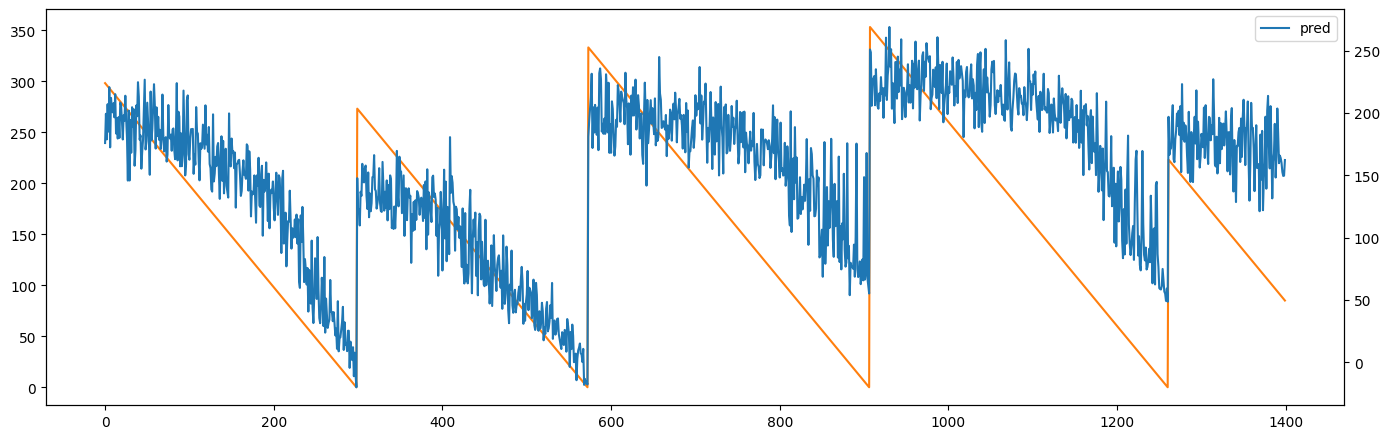

In [13]:
stop = 1400
ts_pred = nn.predict(ts_s[dt_in], verbose=0).ravel() * maxrul
util.plot_rul(ts_pred[:stop], ts['rul'].iloc[:stop], same_scale=False, figsize=figsize)

* The predictions have a decreasing trend (which is good)
* ...But they are _very noisy_ (which is bad)

## Cost Model

**The RUL estimator is meant to be used to define a policy**

Namely, we stop operations when:
$$
f(x; \theta) \leq \varepsilon
$$
* Where $f(x; \theta)$ is the estimated output and $\varepsilon$ is threshold

**Calibrating $\varepsilon$ is best done by relying on a cost model**

* We assume that operating for a time step generates 1 unit of profit
* ...And that failing looses $C$ units of profits w.r.t. performing maintenance
* We also assume we never stop a machine before a "safe" interval $s$

Both $C$ and $s$ are calibrated on data in our example:

In [14]:
failtimes = dt.groupby('machine')['cycle'].max() 
safe_interval, maintenance_cost = failtimes.min(), failtimes.max()

## Cost Model and Threshold Optimization

**We then proceed to choose $\varepsilon$ to optimize the cost**

Optimal threshold for the training set: 8.08


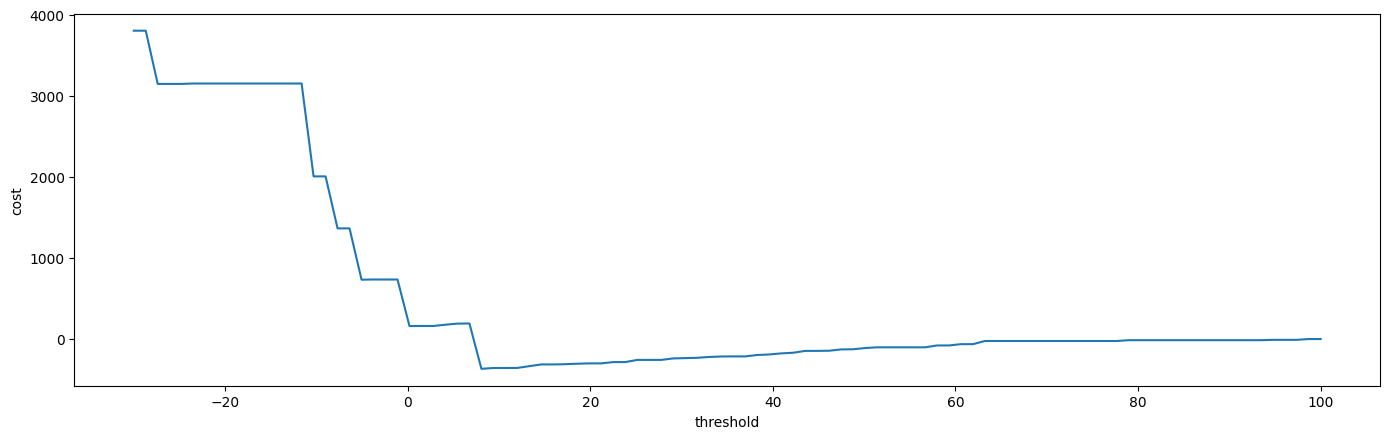

In [15]:
trs_pred = nn.predict(trs_s[dt_in], verbose=0).ravel() * maxrul
cmodel = util.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
th_range = np.linspace(-30, 100, 100)
trs_thr = util.optimize_threshold(trs_s['machine'].values, trs_pred, th_range, cmodel, plot=True, figsize=figsize)
print(f'Optimal threshold for the training set: {trs_thr:.2f}')

## Cost Results

**Let's now check the costs on all datasets**

In [16]:
trs_c, trs_f, trs_sl = cmodel.cost(trs_s['machine'].values, trs_pred, trs_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, trs_thr, return_margin=True)
print(f'Avg. cost: {trs_c/len(trs_mcn):.2f} (supervised), {ts_c/len(ts_mcn):.2f} (test)')

Avg. cost: -52.43 (supervised), 194.00 (test)


* The cost for the training set is good (negative)
* ...But that is not the case for the training set

In [17]:
trs_nm, tru_nm, ts_nm = len(trs_mcn), len(tru_mcn), len(ts_mcn)
print(f'Avg. fails: {trs_f/trs_nm:.2f} (supervised), {ts_f/ts_nm:.2f} (test)')
print(f'Avg. slack: {trs_sl/trs_nm:.2f} (supervised), {ts_sl/len(ts_mcn):.2f} (test)')

Avg. fails: 0.00 (supervised), 0.43 (test)
Avg. slack: 16.57 (supervised), 8.40 (test)


* In particular, there is a _very high failure rate on unseen data_

<div class=big>
<small>Ok, now we are supposed to inject knowledge in ML</small><br>
So, what do we know?
</div>

## From Domain Knowledge...

**We know that the RUL _decreases at a fixed rate_**

* After 1 time step, the RUL will have decreased by 1 unit
* After 2 time steps, the RUL will have decreased by 2 units and so on

**In general, let's consider pairs of examples $(x_i, y_i)$ and $(x_j, y_j)$**

Then we know that:

$$\begin{align}
& y_i - y_j = j - i & \forall i, j = 1..m \ \text{ with: } c_i = c_j
\end{align}$$

* $c_i, c_j$ are the machine for the two samples
* The left-most terms is the difference between the RULs
* $j -i$ is the difference between the sequential indexes of the two samples
* ...Which by construction should be equal to the RUL difference

## ...To Constraints

**We can use the mentioned observation to define a constraint**

We just need to swap the actual RUL values for the model predictions:

$$\begin{align}
& f(x_i; \theta) - f(x_j; \theta) \simeq j - i & \forall i, j = 1..m \ \text{ with: } c_i = c_j
\end{align}$$

* Since the predictions are subject to errors
* ...It's best to enforce _approximate_ equality

In practice, what we have is a set of _soft constraint_

**Moreover, our constraints are _relational_**

...Meaning that each relation involves multiple examples

> **Now that we know which property we want to enforce, how do we achieve it?**